In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

# plotting
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper functions 

In [2]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [3]:
# Measuring time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# A language class

In [ ]:
# Define a language class where words are indexed
SOS_token = 0 # start of sentence
EOS_token = 1 # end of sentence

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
lang = Lang("Esperanto")
lang.addSentence("Lagrange biscruglia longeramente")
lang.addSentence("Lagrange pronunze solopiu")

lang.word2count, lang.word2index, lang.index2word

In [ ]:
# Utilities to read sentence corpus from file

# filtering only small sentence starting with predefined prefixes
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs
    
# filter utility
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# watch inner workings
lang1 = "eng"
lang2 = "fra"
input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse=True)
pairs

# Read dataset

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', reverse=True)

In [ ]:
print(random.choice(pairs))
input_lang.word2count, output_lang.word2count

# seq2seq model

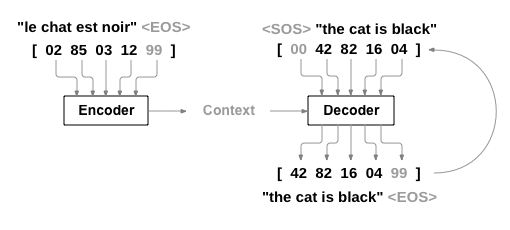

### Encoder model

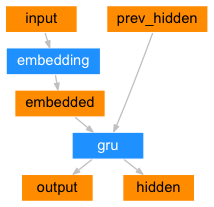

Encoder and decoder will use an Embedding module:

In [ ]:
# an Embedding module containing 5 tensors of size 3
num_dict = 5
embedding_dim = 3
embedding = nn.Embedding(num_dict, embedding_dim)

print("embedding vectors:")
print(embedding.weight.data)

# a batch of 3 samples of 2 indices each
print("example input:")
input = torch.LongTensor([[0, 1],
                          [1, 2],
                          [3,4]])
embedding(input).data

In [49]:
class EncoderRNN(nn.Module):
    ...

### Simple decoder model

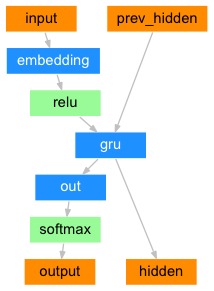

The decoder takes SOS token as first input while the hidden state is initialized from the last hidden state of the encoder networks. From there on, each output of the decoder gets fed back in as input.

In [50]:
class DecoderRNN(nn.Module):
    ...

# Prepare training data

In [ ]:
# get a list of indices of each word in a given sentence
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

i_pair = 30
line = pairs[i_pair][0] 
print(line)
indexes = indexesFromSentence(input_lang, line)
indexes

In [ ]:
# from a list to a tensor of int
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

t = tensorFromSentence(input_lang, line)
print("tensor:", t)
print("tensor shape:", t.shape) # note the added dimension for the bacth

In [12]:
# get a tensor pair from a pair of sentences
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Setup network and optimizers

In [160]:
...

In [161]:
# set optimizers and criterion
learning_rate = 0.01

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()

# Train

In [149]:
# A single training update will look like this:
    
# initial input to decoder will be SOS

# run encoder

# set context

# run decoder (choose teacher forcing randomly with prob. teacher_forcing_ratio)
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing: # feed the target as the next input

else: # use its own predictions as the next input (in this case, stop decoder when it outputs EOS)